# 생체인증보안 1871085 홍채 1차 코드

In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
#tf.debugging.set_log_device_placement(True)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    print(e)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5859576622340420331
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10768720896
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13367941012259910484
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:09:00.0, compute capability: 6.1"
]


In [162]:
# 라이브러리 import
import PIL.Image as pilimg
import numpy as np
import glob
import matplotlib.pyplot as plt
import re

In [163]:
# 이미지 목록
images = glob.glob('./03_iris_training/*.png')
len(images)

128

In [164]:
r = re.compile('\d+')

img = [] # 이미지
label = [] # 라벨

for fname in images:
    l = r.findall(fname)[1]
    label.append(l)
    im = pilimg.open(fname)
    pix = np.array(im)/255. # Normalize
    img.append(pix)

In [165]:
X = np.array(img)
X.shape # img shape

(128, 576, 768, 3)

In [166]:
y = np.array(label, dtype='int32')
y # label

array([38, 12, 54, 56, 19, 51, 20, 48, 10, 45, 16, 13, 28, 29, 32, 34, 40,
       30, 59,  2, 59, 55, 51, 45, 61,  1, 15, 48, 35, 49, 64, 26, 38, 42,
       33,  5, 40, 25, 12, 56,  7, 27, 47, 33, 20, 57, 26, 43,  6, 23, 37,
       44, 17, 52, 21, 64, 27, 22, 31,  4, 10, 39, 19, 55, 41,  4, 58, 24,
        1, 18, 58, 49, 24, 53, 32,  9, 14, 14, 35, 36,  5,  2, 57, 54, 53,
       28, 60, 46, 37, 29, 46, 15, 36, 47, 43, 21, 30,  6, 44, 18, 50, 31,
       11,  3,  8, 22, 42, 50, 62, 41, 61, 63,  9,  3, 16,  7, 39, 60, 34,
       52, 17, 63, 23, 25, 11, 13,  8, 62], dtype=int32)

In [167]:
X[0].shape

(576, 768, 3)

(576, 768, 3)
38


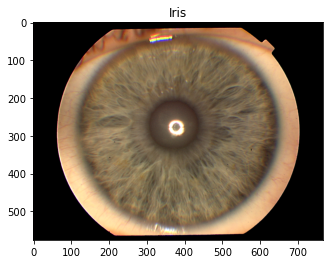

In [168]:
# 홍채 이미지
plt.title('Iris')
plt.imshow(X[0])
print(X[0].shape)
print(y[0])

In [169]:
X[0][300][300]

array([0.36862745, 0.32941176, 0.2627451 ])

In [170]:
X.shape

(128, 576, 768, 3)

## Data Augmentation

In [171]:
# !pip install imgaug

In [179]:
from imgaug import augmenters as iaa
seq = iaa.Sequential([
    # blur images with a sigma of 0 to 0.1
    #iaa.GaussianBlur(sigma=(0, 0.1)),
    iaa.Affine(
        # translate by -1 to +1 percent (per axis)
        translate_percent={"x": (-0.01, 0.01), "y": (-0.01, 0.01)},
        # use nearest neighbour or bilinear interpolation (fast)
        order=[0, 1],
        # if mode is constant, use a cval between 0 and 255
        cval=0
    )
], random_order=True)

def aug_data(X_data, y_data):
    augmentated_data = [] # 생성한 이미지
    augmentated_label = [] # 생성한 이미지의 라벨
    for i in range(len(X)):
        augs = [X[i]] * 4 # 이미지당 2개 추가 생성
        augs = seq.augment_images(augs)
        for aug in augs:
            augmentated_data.append(aug)
            augmentated_label.append(y_data[i])
    
    return augmentated_data, augmentated_label

In [180]:
x_d, y_d = aug_data(X, y) # 이미지 생성

In [181]:
print(len(x_d), len(y_d))

512 512


(576, 768, 3)
38


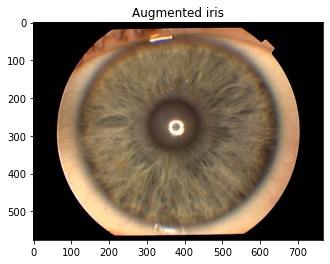

In [182]:
# 생성한 홍채 이미지
plt.title('Augmented iris')
plt.imshow(x_d[0])
print(x_d[0].shape)
print(y_d[0])

In [183]:
# 생성한 이미지
x_d = np.array(x_d)
y_d = np.array(y_d)
print(x_d.shape)
print(y_d.shape)

(512, 576, 768, 3)
(512,)


In [184]:
# 기존 이미지
print(X.shape)
print(y.shape)

(128, 576, 768, 3)
(128,)


In [185]:
# 기존 이미지, 생성 이미지 합치기
X_data = np.concatenate([X, x_d], axis=0)
y_data = np.concatenate([y, y_d], axis=0)
print(X_data.shape)
print(y_data.shape)

(640, 576, 768, 3)
(640,)


In [186]:
# #
# X_data = X
# y_data = y

# Data split

In [187]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data,y_data, test_size=0.2, shuffle=True, stratify=y_data, random_state=101)

In [188]:
X_train=X_train.astype('float32')
y_train=y_train.astype('int32')
X_test=X_test.astype('float32')
y_test=y_test.astype('int32')

In [189]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(512, 576, 768, 3) (512,) (128, 576, 768, 3) (128,)


In [190]:
# Input shape
X_train[0].shape

(576, 768, 3)

In [191]:
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=65)
y_test = to_categorical(y_test, num_classes=65)

# Model

In [192]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Masking, Dense, Flatten, Dropout

In [193]:
# !pip install keras_vggface
# !pip install keras_applications

In [194]:
def build_model():
    learning_rate = 0.00001
    width = 768
    height = 576
    METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy')
    ]
    model = Sequential()
    model.add(Masking(mask_value=0., input_shape=X_train[0].shape)) # 테두리 검정 제외
    model.add(Conv2D(filters=12, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=6, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=6, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer='l2'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(65, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=learning_rate), metrics=METRICS)
    return model

model = build_model()
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_21 (Masking)         (None, 576, 768, 3)       0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 576, 768, 12)      336       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 288, 384, 12)      0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 288, 384, 6)       654       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 144, 192, 6)       0         
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 144, 192, 6)       330       
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 72, 96, 6)       

In [195]:
#Cross validation
from sklearn.model_selection import KFold

kf = KFold(n_splits=4, shuffle=True, random_state=42)
all_history = [] # 결과 저장

def score_model(model, cv=None):
    if cv is None:
        cv = KFold(n_splits=4, random_state=42, shuffle=True)
        
    i=0
    for train_fold_index, val_fold_index in cv.split(X_train, y_train):
        i=i+1
        print('Fold #',i)
        # Get the training data
        X_train_fold, y_train_fold = X_train[train_fold_index], y_train[train_fold_index]
        # Get the validation data
        X_val_fold, y_val_fold = X_train[val_fold_index], y_train[val_fold_index]
        
        x,y,z,w = X_train_fold.shape

        print(X_val_fold.shape)
        print(y_val_fold.shape)
        
        # Fit the model
        model_obj = model.fit(X_train_fold, y_train_fold,
                              epochs=80,
                              #batch_size=32,
                              validation_data=(X_val_fold, y_val_fold), 
                              verbose=1)
        all_history.append(model_obj.history)

# Example of the model in action
score_model(model, cv=kf)
model.save('./irismodel9.h5')

Fold # 1
(128, 576, 768, 3)
(128, 65)
Epoch 1/80
12/12 [==============================] - 2s 140ms/step - loss: 9.2373 - accuracy: 0.0086 - val_loss: 9.1468 - val_accuracy: 0.0078
Epoch 2/80
12/12 [==============================] - 2s 129ms/step - loss: 9.1055 - accuracy: 0.0247 - val_loss: 9.0248 - val_accuracy: 0.0156
Epoch 3/80
12/12 [==============================] - 2s 129ms/step - loss: 8.9821 - accuracy: 0.0170 - val_loss: 8.9058 - val_accuracy: 0.0000e+00
Epoch 4/80
12/12 [==============================] - 2s 130ms/step - loss: 8.8659 - accuracy: 0.0230 - val_loss: 8.7896 - val_accuracy: 0.0078
Epoch 5/80
12/12 [==============================] - 2s 129ms/step - loss: 8.7510 - accuracy: 0.0158 - val_loss: 8.6756 - val_accuracy: 0.0078
Epoch 6/80
12/12 [==============================] - 2s 129ms/step - loss: 8.6270 - accuracy: 0.0293 - val_loss: 8.5667 - val_accuracy: 0.0078
Epoch 7/80
12/12 [==============================] - 2s 129ms/step - loss: 8.5194 - accuracy: 0.0241 - val_

12/12 [==============================] - 2s 130ms/step - loss: 4.5929 - accuracy: 0.4456 - val_loss: 5.0407 - val_accuracy: 0.2891
Epoch 59/80
12/12 [==============================] - 2s 130ms/step - loss: 4.5591 - accuracy: 0.4947 - val_loss: 4.9959 - val_accuracy: 0.2969
Epoch 60/80
12/12 [==============================] - 2s 130ms/step - loss: 4.5098 - accuracy: 0.4827 - val_loss: 4.9550 - val_accuracy: 0.3281
Epoch 61/80
12/12 [==============================] - 2s 130ms/step - loss: 4.3916 - accuracy: 0.5219 - val_loss: 4.9312 - val_accuracy: 0.2969
Epoch 62/80
12/12 [==============================] - 2s 129ms/step - loss: 4.3995 - accuracy: 0.5258 - val_loss: 4.8658 - val_accuracy: 0.3281
Epoch 63/80
12/12 [==============================] - 2s 129ms/step - loss: 4.3141 - accuracy: 0.5504 - val_loss: 4.8307 - val_accuracy: 0.3203
Epoch 64/80
12/12 [==============================] - 2s 130ms/step - loss: 4.3095 - accuracy: 0.5504 - val_loss: 4.8031 - val_accuracy: 0.3359
Epoch 65/80

12/12 [==============================] - 2s 128ms/step - loss: 1.4375 - accuracy: 0.9974 - val_loss: 1.4020 - val_accuracy: 1.0000
Epoch 13/80
12/12 [==============================] - 2s 130ms/step - loss: 1.4297 - accuracy: 0.9974 - val_loss: 1.4025 - val_accuracy: 1.0000
Epoch 14/80
12/12 [==============================] - 2s 129ms/step - loss: 1.4276 - accuracy: 0.9948 - val_loss: 1.3909 - val_accuracy: 1.0000
Epoch 15/80
12/12 [==============================] - 2s 129ms/step - loss: 1.4112 - accuracy: 1.0000 - val_loss: 1.3827 - val_accuracy: 1.0000
Epoch 16/80
12/12 [==============================] - 2s 129ms/step - loss: 1.3989 - accuracy: 1.0000 - val_loss: 1.3810 - val_accuracy: 1.0000
Epoch 17/80
12/12 [==============================] - 2s 129ms/step - loss: 1.3898 - accuracy: 1.0000 - val_loss: 1.3703 - val_accuracy: 1.0000
Epoch 18/80
12/12 [==============================] - 2s 132ms/step - loss: 1.3777 - accuracy: 1.0000 - val_loss: 1.3646 - val_accuracy: 1.0000
Epoch 19/80

12/12 [==============================] - 2s 129ms/step - loss: 0.8495 - accuracy: 1.0000 - val_loss: 0.8588 - val_accuracy: 1.0000
Epoch 47/80
12/12 [==============================] - 2s 133ms/step - loss: 0.8459 - accuracy: 1.0000 - val_loss: 0.8548 - val_accuracy: 1.0000
Epoch 48/80
12/12 [==============================] - 2s 130ms/step - loss: 0.8417 - accuracy: 1.0000 - val_loss: 0.8516 - val_accuracy: 1.0000
Epoch 49/80
12/12 [==============================] - 2s 131ms/step - loss: 0.8375 - accuracy: 1.0000 - val_loss: 0.8476 - val_accuracy: 1.0000
Epoch 50/80
12/12 [==============================] - 2s 131ms/step - loss: 0.8337 - accuracy: 1.0000 - val_loss: 0.8434 - val_accuracy: 1.0000
Epoch 51/80
12/12 [==============================] - 2s 130ms/step - loss: 0.8296 - accuracy: 1.0000 - val_loss: 0.8407 - val_accuracy: 1.0000
Epoch 52/80
12/12 [==============================] - 2s 130ms/step - loss: 0.8256 - accuracy: 1.0000 - val_loss: 0.8369 - val_accuracy: 1.0000
Epoch 53/80

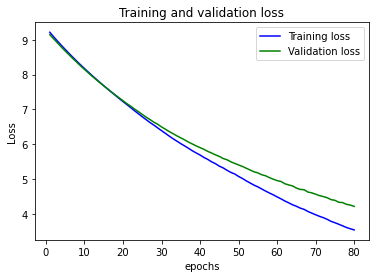

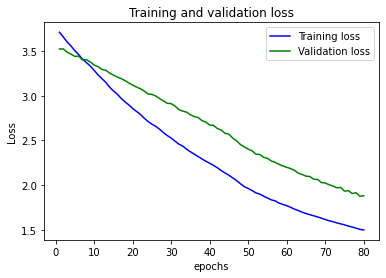

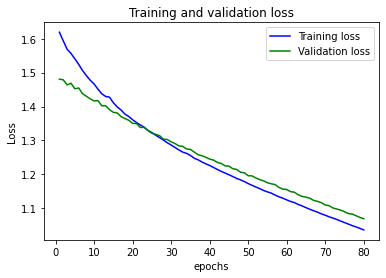

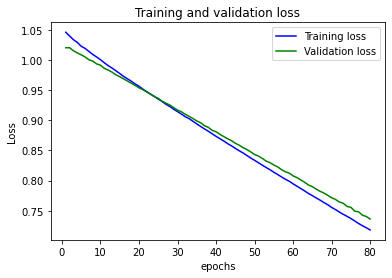

In [196]:
# Loss
for i in range(4):
    loss = all_history[i].get('loss') # train
    val_loss = all_history[i].get('val_loss') # val
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'b', label='Training loss')  # ‘b’는 파란색 실선을 의미합니다.
    plt.plot(epochs, val_loss, 'g', label='Validation loss') # ‘g’는 초록색 실선을 의미합니다.
    plt.title('Training and validation loss')
    plt.xlabel('epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

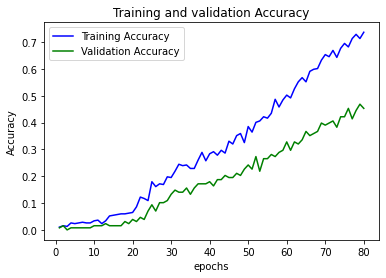

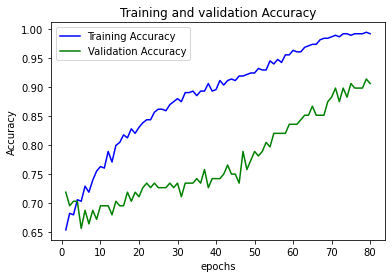

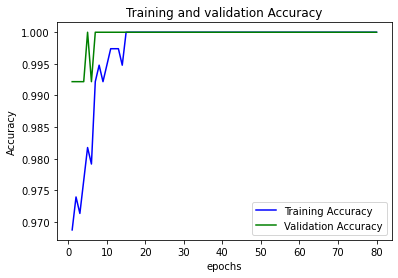

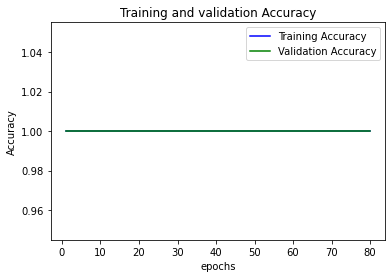

In [197]:
# Accuracy
for i in range(4):
    loss = all_history[i].get('accuracy') # train
    val_loss = all_history[i].get('val_accuracy') # val
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'b', label='Training Accuracy')  # ‘b’는 파란색 실선을 의미합니다.
    plt.plot(epochs, val_loss, 'g', label='Validation Accuracy') # ‘g’는 초록색 실선을 의미합니다.
    plt.title('Training and validation Accuracy')
    plt.xlabel('epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [198]:
preds = np.argmax(model.predict(X_test), axis=1)
preds

array([16, 30, 47, 54, 18, 27, 21, 14, 34, 34, 45, 52, 51, 46,  2, 46, 30,
       19, 53, 36,  5, 49,  3, 25, 31, 51,  1, 20,  7, 26, 41,  9, 48, 32,
       40, 23, 10, 60,  1, 17, 16,  2, 17, 23, 21,  6, 31, 58, 12, 50, 60,
       61, 64, 50, 47, 55, 39, 45, 41, 57,  5,  8, 36, 14, 43, 38, 24, 59,
       28,  4,  3, 35, 37, 22, 49, 42, 53, 44, 55, 15,  9,  2, 58, 11, 32,
       62, 64, 44, 11, 13, 37, 18, 42, 48, 61, 20, 33, 28, 40, 57, 62, 38,
       59, 12, 43, 63, 22, 29, 35, 24, 39, 19, 54, 27, 26, 56, 13, 25, 56,
        6, 15, 63, 10,  8, 33,  4,  7, 52])

In [199]:
y_test_origin = np.argmax(y_test, axis=1)
y_test_origin

array([16, 30, 47, 54, 18, 27, 21, 14, 34, 34, 45, 52, 51, 46,  2, 46, 30,
       19, 53, 36,  5, 49,  3, 25, 31, 51,  1, 20,  7, 26, 41,  9, 48, 32,
       40, 23, 10, 60,  1, 17, 16,  2, 17, 23, 21,  6, 31, 58, 12, 50, 60,
       61, 64, 50, 29, 55, 39, 45, 41, 57,  5,  8, 36, 14, 43, 38, 24, 59,
       28,  4,  3, 35, 37, 22, 49, 42, 53, 44, 55, 15,  9, 47, 58, 11, 32,
       62, 64, 44, 11, 13, 37, 18, 42, 48, 61, 20, 33, 28, 40, 57, 62, 38,
       59, 12, 43, 63, 22, 29, 35, 24, 39, 19, 54, 27, 26, 56, 13, 25, 56,
        6, 15, 63, 10,  8, 33,  4,  7, 52])

(576, 768, 3)
예측:  30
실제:  30


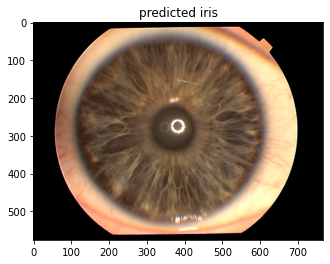

In [200]:
# 예측결과
plt.title('predicted iris')
this_img = X_test[1]
plt.imshow(this_img)
print(this_img.shape)
print('예측: ', preds[1])
print('실제: ', y_test_origin[1])

# Result

In [201]:
from sklearn.metrics import mean_squared_error
# rmse
rmse = np.sqrt(mean_squared_error(y_test_origin, preds)) 
print("RMSE: %f" % (rmse))

RMSE: 4.283872


In [202]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test_origin,preds))

[[2 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 2]]


In [203]:
from sklearn.metrics import classification_report
print(classification_report(y_test_origin,preds, zero_division=1))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       0.67      1.00      0.80         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         2
          16       1.00      1.00      1.00         2
          17       1.00      1.00      1.00         2
          18       1.00    

## Test

In [204]:
images = glob.glob('./03_iris_test/*.png')
len(images)

256

In [205]:
r = re.compile('\d+')

img = [] # 이미지
img_num = [] # 이미지 번호

for fname in images:
    num = r.findall(fname)[1]
    img_num.append(num)
    im = pilimg.open(fname)
    pix = np.array(im)/255. # Normalize
    img.append(pix)

(576, 768, 3)
51


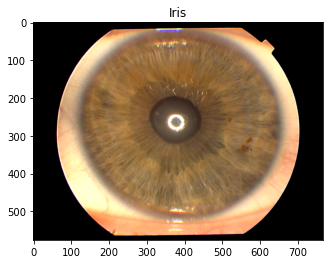

In [206]:
# 얼굴 이미지
plt.title('Iris')
plt.imshow(img[0])
print(img[0].shape)
print(img_num[0])

In [207]:
X = np.array(img)
X = X.astype('float32')

In [208]:
preds = np.argmax(model.predict(X), axis=1)
preds

array([49, 48, 40, 35, 23, 34, 35, 53, 19, 57, 22, 61, 19, 48, 51, 32, 17,
       41,  5, 35, 33, 23, 39, 36, 14, 37, 28, 48, 48, 24, 32,  8, 61, 53,
       23, 28, 23, 30, 14, 21, 32, 42, 10, 15, 33, 36, 54, 31,  6, 23, 21,
       16, 40, 57, 21, 33, 63, 57, 21, 56,  2, 61, 34, 44, 41, 61,  3, 42,
       27, 16, 33, 64, 36, 27, 21, 24, 39, 10, 45, 21, 32, 61, 23, 45,  6,
       47, 62, 32,  7, 21, 32, 14, 46, 58,  6, 24, 64, 28, 63, 11, 32, 34,
       57, 17,  2, 22, 49, 21,  3, 64, 10, 15, 28, 33, 12, 34, 33,  5, 47,
       28, 31, 32, 36,  2, 40, 21, 17,  7, 33, 42, 48, 40, 41, 56, 16, 57,
        6, 64, 41, 45, 42, 21, 11, 38, 50, 55, 57, 43, 20, 39, 56, 45, 36,
       51, 35, 33, 24, 62, 24, 62, 39, 28, 29, 41,  5, 54, 10, 60, 23, 32,
        1, 48, 32,  1, 50, 39,  3, 64,  2, 57, 64, 47, 19, 46, 43, 11, 11,
       34, 17, 62, 17, 11, 34, 49, 52, 41, 32, 32, 36, 52, 26, 11, 63, 44,
       13, 32, 41,  2, 15, 12, 11, 11, 46, 53,  2, 32, 36, 57, 17, 57, 21,
       32, 31, 19, 32, 34

In [209]:
import pandas as pd
res_df = pd.DataFrame(img_num, columns=['Image'], dtype='int32')
res_df['Answer'] = pd.Series(preds, dtype='int32')
res_df.sort_values(by=['Image'], axis=0, inplace=True)
res_df

,Image,Answer
92,1,46
83,2,45
245,3,23
212,4,46
217,5,57
...,...,...
141,252,21
229,253,14
177,254,64
25,255,37


In [210]:
res_df['Answer'].value_counts()

32    16
21    12
11    10
57     9
33     9
23     9
34     8
17     8
41     7
36     7
2      7
64     7
39     6
24     6
28     6
48     6
42     5
62     5
61     5
46     5
40     4
10     4
5      4
16     4
6      4
35     4
7      4
45     4
56     4
63     4
19     4
14     4
49     3
44     3
52     3
53     3
47     3
3      3
50     3
15     3
22     3
12     3
31     3
43     2
27     2
38     2
54     2
51     2
1      2
29     1
30     1
55     1
26     1
8      1
58     1
60     1
37     1
13     1
20     1
Name: Answer, dtype: int64

In [211]:
res_df.to_csv('./1871085_홍채_1차_답안v9.csv', index=False)